In [1]:
import pandas as pd
import numpy as np

# ================================
# 1. Load & clean WTO tariff data
# ================================


wto_path = "adb_mfn_applied_duty_04_11_2025_02_46_45.csv"

wto = pd.read_csv(wto_path)


wto.columns = wto.columns.str.strip()
wto.columns = wto.columns.str.replace('\ufeff', '', regex=True)

print("Columns after cleaning header:")
print(wto.columns.tolist(), "\n")


mask = wto["indicator"].str.contains(
    "MFN_applied_duty_simple_average_in_percentage",
    case=False
)
wto_filtered = wto[mask].copy()

print(f"Rows after filtering MFN simple average: {len(wto_filtered)}")

# Select & rename relevant columns
wto_clean = wto_filtered.rename(columns={
    "product_code": "hs_code",
    "value": "tariff_rate",
    "reporter_name": "country_importer"
})[["hs_code", "year", "tariff_rate", "country_importer"]]


wto_clean["hs_code"] = wto_clean["hs_code"].astype(str).str.zfill(6)


wto_clean["tariff_rate"] = pd.to_numeric(
    wto_clean["tariff_rate"],
    errors="coerce"
) / 100.0


wto_clean = wto_clean.dropna(subset=["tariff_rate"])

print("\nSample of cleaned WTO tariff data:")
print(wto_clean.head(), "\n")


wto_clean = (
    wto_clean
    .groupby(["hs_code", "year"], as_index=False)["tariff_rate"]
    .mean()
)

print("After grouping by hs_code & year:")
print(wto_clean.head(), "\n")



np.random.seed(42)  # for reproducibility

num_suppliers = 500

available_hs = wto_clean["hs_code"].unique()
available_years = wto_clean["year"].unique()

supplier_df = pd.DataFrame({
    "supplier_id": range(1, num_suppliers + 1),
    "country_origin": np.random.choice(
        ["China", "Vietnam", "Mexico", "Germany", "India", "United States"],
        size=num_suppliers
    ),
    "hs_code": np.random.choice(available_hs, size=num_suppliers),
    "year": np.random.choice(available_years, size=num_suppliers),
    "shipping_cost": np.random.uniform(50, 300, size=num_suppliers),
    "lead_time_days": np.random.randint(5, 60, size=num_suppliers),
    "defect_rate": np.random.uniform(0.00, 0.08, size=num_suppliers),
    "base_cost": np.random.uniform(500, 2000, size=num_suppliers)
})

print("Sample of synthetic supplier data BEFORE merge:")
print(supplier_df.head(), "\n")

# ==========================================
# 3. Merge WTO tariffs into supplier dataset
# ==========================================

merged_df = supplier_df.merge(
    wto_clean,          # has hs_code, year, tariff_rate
    how="left",
    on=["hs_code", "year"]
)


median_tariff = merged_df["tariff_rate"].median()
merged_df["tariff_rate"] = merged_df["tariff_rate"].fillna(median_tariff)



merged_df["total_landed_cost"] = (
    merged_df["base_cost"]
    + merged_df["shipping_cost"]
    + merged_df["base_cost"] * merged_df["tariff_rate"]
)

print("Sample of final modeling dataset:")
print(merged_df.head(), "\n")


output_path = "synthetic_supplier_tariff_data.csv"
merged_df.to_csv(output_path, index=False)

print(f"✅ Synthetic ML dataset saved to: {output_path}")
print(f"Rows: {len(merged_df)}, Columns: {len(merged_df.columns)}")


FileNotFoundError: [Errno 2] No such file or directory: 'adb_mfn_applied_duty_04_11_2025_02_46_45.csv'

In [ ]:
# Fix versions so SHAP / Numba work nicely together
!pip install -q "numpy==1.24.4" "scipy==1.10.1" "numba==0.57.1"

# Install modeling libraries
!pip install -q shap==0.44.0 xgboost joblib scikit-learn pandas matplotlib# Fix versions so SHAP / Numba work nicely together
!pip install -q "numpy==1.24.4" "scipy==1.10.1" "numba==0.57.1"

# Install modeling libraries
!pip install -q shap==0.44.0 xgboost joblib scikit-learn pandas matplotlib



In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import shap
import joblib
import matplotlib.pyplot as plt

# ============================================
# 1. Load dataset
# ============================================
DATA_PATH = "synthetic_supplier_tariff_data.csv"
df = pd.read_csv(DATA_PATH)

print("Data sample:")
print(df.head(), "\n")
print("Columns:", df.columns.tolist(), "\n")

# ============================================
# 2. Define features & target
# ============================================
TARGET_COL = "total_landed_cost"

numeric_features = [
    "shipping_cost",
    "lead_time_days",
    "defect_rate",
    "base_cost",
    "tariff_rate",
    "year",
]

categorical_features = [
    "country_origin",
    "hs_code"
]

df["country_origin"] = df["country_origin"].astype(str)
df["hs_code"] = df["hs_code"].astype(str)

X = df[numeric_features + categorical_features]
y = df[TARGET_COL]

# ============================================
# 3. Train / Val / Test split
# ============================================
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765,  # so ≈ 70/15/15
    random_state=42
)

print("Shapes:")
print("  Train:", X_train.shape)
print("  Val  :", X_val.shape)
print("  Test :", X_test.shape, "\n")

# ============================================
# 4. Preprocessing
# ============================================
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# ============================================
# 5. Helper evaluation functions
# ============================================
def evaluate_regression(model, X_train, y_train, X_val, y_val, model_name="model"):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results = {}

    for split_name, y_true, y_pred in [
        ("train", y_train, y_train_pred),
        ("val", y_val, y_val_pred),
    ]:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        results[split_name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

        print(f"=== {model_name} ({split_name}) ===")
        print(f"MAE : {mae:,.2f}")
        print(f"RMSE: {rmse:,.2f}")
        print(f"R²  : {r2:,.3f}")
        print()

    return results

def get_val_mae(results_dict):
    return results_dict["val"]["MAE"]

# ============================================
# 6. Model 1: Linear Regression
# ============================================
linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)

linreg_results = evaluate_regression(
    linreg, X_train, y_train, X_val, y_val, model_name="LinearRegression"
)

# ============================================
# 7. Model 2: Random Forest
# ============================================
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_, "\n")

rf_best = rf_grid.best_estimator_

rf_results = evaluate_regression(
    rf_best, X_train, y_train, X_val, y_val, model_name="RandomForest"
)

# ============================================
# 8. Model 3: XGBoost
# ============================================
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=300,
        n_jobs=-1,
        tree_method="hist",
    )),
])

xgb_param_grid = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

xgb_grid = GridSearchCV(
    xgb,
    param_grid=xgb_param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

xgb_grid.fit(X_train, y_train)
print("Best XGB params:", xgb_grid.best_params_, "\n")

xgb_best = xgb_grid.best_estimator_

xgb_results = evaluate_regression(
    xgb_best, X_train, y_train, X_val, y_val, model_name="XGBoost"
)

# ============================================
# 9. Pick best model by validation MAE
# ============================================
model_results = {
    "LinearRegression": linreg_results,
    "RandomForest": rf_results,
    "XGBoost": xgb_results,
}

best_model_name = min(
    model_results.keys(),
    key=lambda name: get_val_mae(model_results[name])
)

print(f"🏆 Best model based on validation MAE: {best_model_name}\n")

if best_model_name == "LinearRegression":
    best_model = linreg
elif best_model_name == "RandomForest":
    best_model = rf_best
else:
    best_model = xgb_best

# ============================================
# 10. Final evaluation on TEST set
# ============================================
def evaluate_on_test(model, X_test, y_test, model_name="best_model"):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"=== {model_name} (TEST) ===")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:,.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

test_results = evaluate_on_test(best_model, X_test, y_test, model_name=best_model_name)

# ============================================
# 11. Refit on train+val and run SHAP (tree models)
# ============================================
best_model.fit(X_train_val, y_train_val)

X_train_val_transformed = best_model.named_steps["preprocessor"].transform(X_train_val)
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

if best_model_name in ["RandomForest", "XGBoost"]:
    model_for_shap = best_model.named_steps["model"]

    explainer = shap.TreeExplainer(model_for_shap)
    shap_values = explainer.shap_values(X_train_val_transformed)

    # SHAP summary plots (run in notebook)
    shap.summary_plot(shap_values, X_train_val_transformed, feature_names=feature_names)
    shap.summary_plot(
        shap_values,
        X_train_val_transformed,
        feature_names=feature_names,
        plot_type="bar"
    )
else:
    print("Best model is LinearRegression – SHAP TreeExplainer not used here.")

# ============================================
# 12. Save best model
# ============================================
import os
os.makedirs("models", exist_ok=True)
model_path = f"models/{best_model_name}_tariff_supplier_model.pkl"
joblib.dump(best_model, model_path)
print(f"\n💾 Saved best model to: {model_path}")


Data sample:
   supplier_id country_origin  hs_code  year  shipping_cost  lead_time_days  \
0            1        Germany   940159  2025     240.056965              21   
1            2          India   310540  2025     198.909685              39   
2            3         Mexico   844315  2025     167.894047              17   
3            4          India   390910  2025     152.960229              45   
4            5          India   540821  2025     137.217067              43   

   defect_rate    base_cost  tariff_rate  total_landed_cost  
0     0.043389   566.892363       0.0000         806.949328  
1     0.076118   554.431434       0.0000         753.341119  
2     0.067773   913.579780       0.0000        1081.473827  
3     0.073139   913.418508       0.0325        1096.064838  
4     0.065101  1680.689904       0.1490        2068.329766   

Columns: ['supplier_id', 'country_origin', 'hs_code', 'year', 'shipping_cost', 'lead_time_days', 'defect_rate', 'base_cost', 'tariff_rate'

/home/dab82c77-da3b-430f-a030-a9983a02309e/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dab82c77-da3b-430f-a030-a9983a02309e/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dab82c77-da3b-430f-a030-a9983a02309e/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dab82c77-da3b-430f-a030-a9983a02309e/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Best RF params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200} 

=== RandomForest (train) ===
MAE : 19.15
RMSE: 76.50
R²  : 0.975

=== RandomForest (val) ===
MAE : 51.70
RMSE: 102.36
R²  : 0.956

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best XGB params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__subsample': 0.8} 

=== XGBoost (train) ===
MAE : 5.59
RMSE: 6.87
R²  : 1.000

=== XGBoost (val) ===
MAE : 26.18
RMSE: 53.74
R²  : 0.988

🏆 Best model based on validation MAE: LinearRegression

=== LinearRegression (TEST) ===
MAE : 25.84
RMSE: 31.45
R²  : 0.995
Best model is LinearRegression – SHAP TreeExplainer not used here.

💾 Saved best model to: models/LinearRegression_tariff_supplier_model.pkl


/tmp/ipykernel_256/1502484364.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


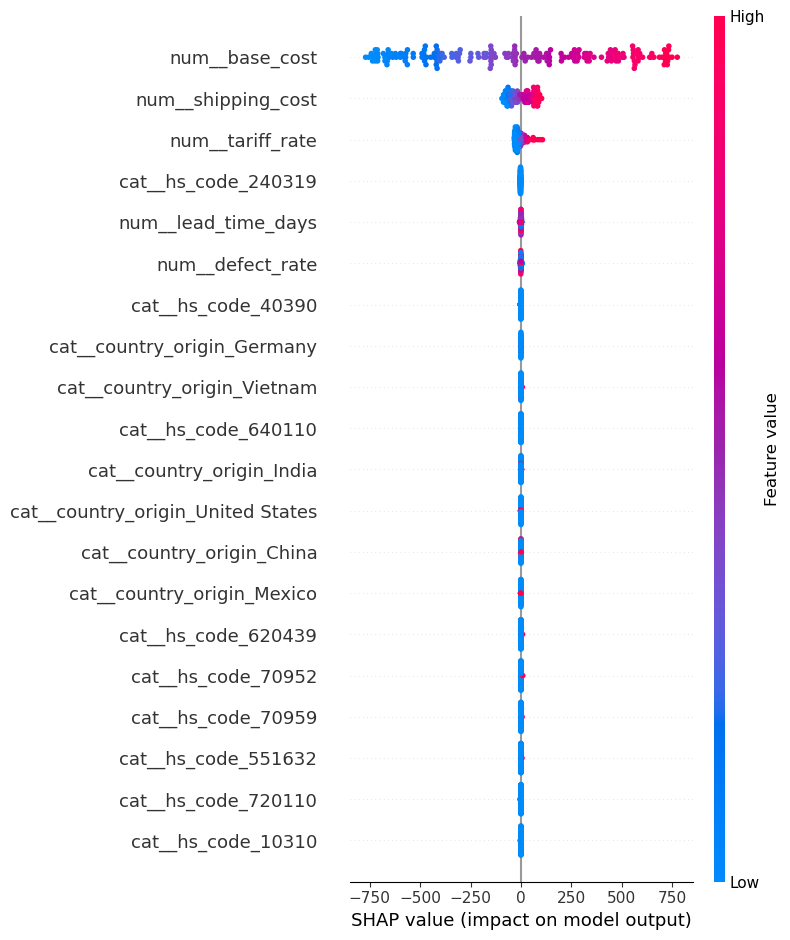

/tmp/ipykernel_256/1502484364.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


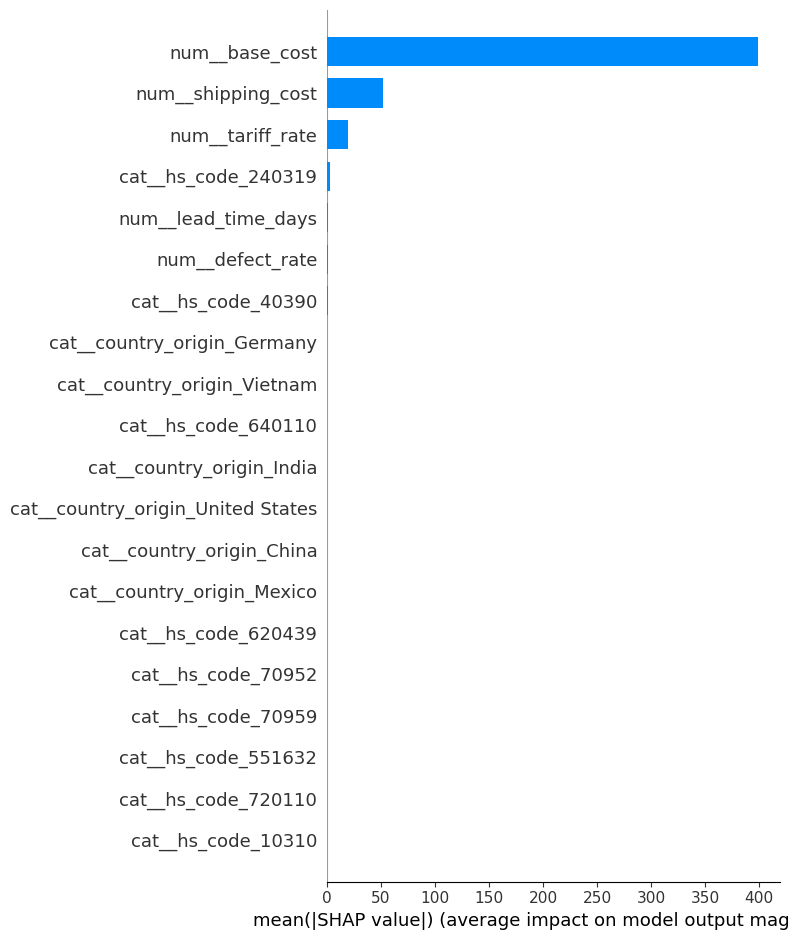

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

# 0) Make sure rf_best, X_train_val, y_train_val exist from your previous code

# 1) Fit RF on full train+val for interpretation
rf_best.fit(X_train_val, y_train_val)

# 2) Transform features with the pipeline preprocessor
X_train_val_transformed = rf_best.named_steps["preprocessor"].transform(X_train_val)
feature_names = rf_best.named_steps["preprocessor"].get_feature_names_out()

# 3) Ensure we have a dense float32 NumPy array (not sparse / object)
if sp.issparse(X_train_val_transformed):
    X_all = X_train_val_transformed.toarray().astype(np.float32)
else:
    X_all = np.asarray(X_train_val_transformed, dtype=np.float32)

# Optional: guard against any NaNs (shouldn't really be there)
X_all = np.nan_to_num(X_all)

# 4) Sample rows for SHAP (for speed)
n_sample = min(200, X_all.shape[0])
sample_idx = np.random.choice(X_all.shape[0], size=n_sample, replace=False)
X_sample = X_all[sample_idx]

# 5) Build SHAP TreeExplainer & compute SHAP values
rf_model_only = rf_best.named_steps["model"]
explainer = shap.TreeExplainer(rf_model_only)
shap_values = explainer.shap_values(X_sample)

# 6) SHAP summary dot plot
plt.figure()
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.savefig("shap_rf_summary_dot.png", bbox_inches="tight")
plt.show()

# 7) SHAP summary bar plot
plt.figure()
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.savefig("shap_rf_summary_bar.png", bbox_inches="tight")
plt.show()
